In [1]:
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(patchwork)
library(Seurat)
library(SeuratDisk)
library(ggplot2)
library(dplyr)
library(DESeq2)
library(pheatmap)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Error in library(SeuratDisk) : there is no package called ‘SeuratDisk’


RInterpreterError: Failed to parse and evaluate line 'library(patchwork)\nlibrary(Seurat)\nlibrary(SeuratDisk)\nlibrary(ggplot2)\nlibrary(dplyr)\nlibrary(DESeq2)\nlibrary(pheatmap)\n'.
R error message: 'Error in library(SeuratDisk) : there is no package called ‘SeuratDisk’'
R stdout:
Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Error in library(SeuratDisk) : there is no package called ‘SeuratDisk’

In [4]:
%%R
cluster = FALSE

In [16]:
%%R
# Check if the directory exists before setting it
if (cluster) {
  dir_path <- "/beegfs/scratch/ric.broccoli/kubacki.michal/GSE171266"
} else {
  dir_path <- "/home/michal/WSL_GitHub/SRF_microglia/data/GSE171266"
}

if (dir.exists(dir_path)) {
  setwd(dir_path)
} else {
  warning(paste("Directory", dir_path, "does not exist. Working directory not changed."))
}

# Load single-cell data
load_10x_data <- function(path, sample_name) {
  if (!dir.exists(path)) {
    stop(paste("Directory", path, "does not exist."))
  }
  data <- Read10X(data.dir = path)
  seurat_obj <- CreateSeuratObject(counts = data, project = sample_name, min.cells = 3, min.features = 200)
  seurat_obj$sample <- sample_name
  return(seurat_obj)
}

In addition: Warning message:
In (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  :
  Directory /home/michal/WSL_GitHub/SRF_microglia/data/GSE171266 does not exist. Working directory not changed.


In [19]:
%%R
wt_data <- load_10x_data("./data/GSM5221533_1", "WT_D686D")
mut_data <- load_10x_data("./data/GSM5221534_2", "Mut_D868N")

|--------------------------------------------------|
|==================================================|


In [20]:
%%R
# Merge datasets
combined_data <- merge(wt_data, mut_data)

In [37]:
%%R
# Display summary of combined_data
print(combined_data)

# Save the Seurat object to a file
saveRDS(combined_data, file = "./output/combined_data.rds")

# Confirm the file was saved
if (file.exists("./output/combined_data.rds")) {
  cat("Seurat object saved successfully to combined_data.rds\n")
} else {
  cat("Error: Failed to save Seurat object\n")
}

An object of class Seurat 
22980 features across 157695 samples within 1 assay 
Active assay: RNA (22980 features, 0 variable features)
 2 layers present: counts.WT_D686D, counts.Mut_D868N
Seurat object saved successfully to combined_data.rds


In [5]:
%%R
# Load the Seurat object from the saved file
combined_data <- readRDS("./output/combined_data.rds")

# Verify that the object was loaded correctly
if (is(combined_data, "Seurat")) {
  cat("Seurat object loaded successfully from combined_data.rds\n")
  print(combined_data)
} else {
  cat("Error: Failed to load Seurat object or loaded object is not a Seurat object\n")
}

Seurat object loaded successfully from combined_data.rds
An object of class Seurat 
22980 features across 157695 samples within 1 assay 
Active assay: RNA (22980 features, 0 variable features)
 2 layers present: counts.WT_D686D, counts.Mut_D868N


In [6]:
%%R
# Calculate quality control metrics
combined_data[["percent.mt"]] <- PercentageFeatureSet(combined_data, pattern = "^MT-")

In [7]:
%%R
head(combined_data@meta.data)

                     orig.ident nCount_RNA nFeature_RNA   sample percent.mt
AAACCCAAGAGCAACC-1_1   WT_D686D        529          352 WT_D686D   3.024575
AAACCCAAGAGGTATT-1_1   WT_D686D        312          207 WT_D686D   6.730769
AAACCCAAGAGTCAAT-1_1   WT_D686D        328          242 WT_D686D   3.048780
AAACCCAAGATGACAT-1_1   WT_D686D        299          222 WT_D686D   4.682274
AAACCCAAGATTTGCC-1_1   WT_D686D        292          221 WT_D686D   8.219178
AAACCCAAGCGGTAAC-1_1   WT_D686D       4673         2011 WT_D686D  10.464370


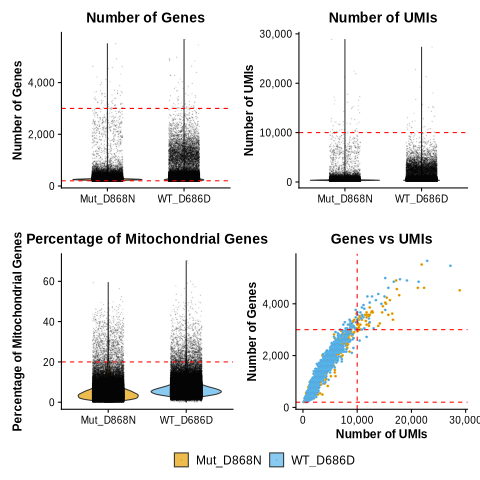

In [10]:
%%R
library(cowplot)
plot_qc_metrics <- function(seurat_obj) {
  # Ensure we're using the correct assay
  DefaultAssay(seurat_obj) <- "RNA"
  
  # Extract metadata and ensure 'sample' is a factor
  metadata <- seurat_obj@meta.data %>%
    mutate(sample = factor(sample))
  
  # Custom theme
  my_theme <- theme_cowplot() +
    theme(
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      legend.position = "bottom",
      legend.title = element_blank(),
      strip.background = element_blank(),
      strip.text = element_text(size = 12, face = "bold")
    )

  # Color palette
  colors <- c("#E69F00", "#56B4E9")

  # Function to create violin plot with reduced point density
  create_violin <- function(feature, title, yintercept = NULL) {
    p <- ggplot(metadata, aes(x = sample, y = !!sym(feature), fill = sample)) +
      geom_violin(alpha = 0.7) +
      geom_jitter(size = 0.1, alpha = 0.1, width = 0.2) +
      scale_fill_manual(values = colors) +
      labs(title = title, y = title, x = "") +
      my_theme

    if (!is.null(yintercept)) {
      p <- p + geom_hline(yintercept = yintercept, color = "red", linetype = "dashed")
    }
    
    return(p)
  }

  p1 <- create_violin("nFeature_RNA", "Number of Genes", c(200, 3000)) +
    scale_y_continuous(labels = scales::comma)

  p2 <- create_violin("nCount_RNA", "Number of UMIs", 10000) +
    scale_y_continuous(labels = scales::comma)

  p3 <- create_violin("percent.mt", "Percentage of Mitochondrial Genes", 20)

  # Scatter plot with hexbin to reduce overplotting
  p4 <- ggplot(metadata, aes(x = nCount_RNA, y = nFeature_RNA, color = sample)) +
    geom_hex(bins = 100, aes(fill = ..count..), show.legend = FALSE) +
    scale_fill_viridis_c() +
    geom_vline(xintercept = 10000, color = "red", linetype = "dashed") +
    geom_hline(yintercept = c(200, 3000), color = "red", linetype = "dashed") +
    labs(title = "Genes vs UMIs", x = "Number of UMIs", y = "Number of Genes") +
    scale_color_manual(values = colors) +
    my_theme +
    scale_x_continuous(labels = scales::comma) +
    scale_y_continuous(labels = scales::comma)

  # Combine plots
  combined_plot <- (p1 + p2) / (p3 + p4) +
    plot_layout(guides = "collect") &
    theme(legend.position = "bottom")

  return(combined_plot)
}

# Create and display plots in notebook
print(plot_qc_metrics(combined_data))

In [11]:
%%R
# Filter cells (you can modify these thresholds based on the plots)
combined_data <- subset(combined_data, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & 
                        nCount_RNA < 10000 & percent.mt < 20)

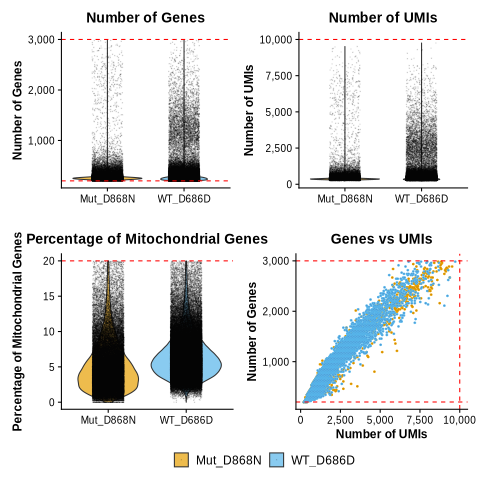

In [12]:
%%R
# Create and display plots in notebook
print(plot_qc_metrics(combined_data))

In [14]:
%%R
# Normalize data
combined_data <- NormalizeData(combined_data)

Normalizing layer: counts.WT_D686D
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Normalizing layer: counts.Mut_D868N
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


In [15]:
%%R
# Find variable features
combined_data <- FindVariableFeatures(combined_data, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts.WT_D686D
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts.Mut_D868N
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


In [17]:
%%R
# Scale data
# all_genes <- rownames(combined_data)
variable_genes <- VariableFeatures(combined_data)
combined_data <- ScaleData(combined_data, features = variable_genes)

Centering and scaling data matrix
  |======================================================================| 100%


In [18]:
%%R
# Run PCA
combined_data <- RunPCA(combined_data, features = VariableFeatures(object = combined_data))

PC_ 1 
Positive:  KCNQ1OT1, CDH2, HSP90B1, TPBG, WLS, NEAT1, MT-ND5, KDM5B, FZD3, RMST 
	   MALAT1, APLP2, GABPB1-AS1, HSPA5, ITM2B, SNHG14, PRRC2C, MDK, CALR, APP 
	   MT-ND2, TMCO1, BSG, SOX2-OT, MSI2, TMBIM6, RSPO2, SOX2, CALU, TSPAN3 
Negative:  HIST1H4C, RBP1, RPS4Y1, STMN2, FABP7, DAPL1, GAPDH, GNRH1, TMSB4X, HES6 
	   LHX2, HMX1, RAX, CRABP1, CALB2, DLX5, GAD2, DLX2, SFRP1, SNCG 
	   MGP, SST, GAL, TAC1, HIST1H1D, CHCHD2, KIAA1211L, CAGE1, HOXB9, HCG9 
PC_ 2 
Positive:  TTR, MT-ND5, FTL, MT-CO3, MT-ATP6, RPS8, ID3, APOE, TRPM3, WLS 
	   MT-ND2, MT-ND3, CRABP2, MT-CO2, CA2, TPBG, MT-CYB, WNT4, CFAP126, PIFO 
	   DDIT3, DNALI1, RSPO1, TUBA1C, CRIP1, FAM183A, KIF9, CCNO, SERPINF1, NR2F2 
Negative:  GAPDH, HIST1H4C, CRABP1, RBP1, SFRP2, DAPL1, RPS4Y1, FABP7, CKB, HMGB1 
	   SFRP1, HMX1, LHX2, IGFBP2, HES6, RAX, SIX6, PTMA, TPI1, ID4 
	   TUBB3, STMN2, CPE, TUBB, MAB21L1, PCLAF, H1FX, MEIS2, VSX2, LINC00461 
PC_ 3 
Positive:  CFAP126, MALAT1, TRPM3, TTR, FTL, NEAT1, CA2, PIFO, CRABP2

In [19]:
%%R
# Find neighbors and run UMAP
combined_data <- FindNeighbors(combined_data, dims = 1:40)
combined_data <- RunUMAP(combined_data, dims = 1:40)

Computing nearest neighbor graph
Computing SNN
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session
15:24:23 UMAP embedding parameters a = 0.9922 b = 1.112
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
15:24:23 Read 154191 rows and found 40 numeric columns
15:24:23 Using Annoy for neighbor search, n_neighbors = 30
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
15:24:23 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
15:24:35 Writing NN index file to temp file /tmp/RtmpGjuD9a/file1a98d3992e99a
15:24:35 Searching Annoy index using 1 thread, search_k = 3000
15:26:00 Annoy recall = 100%
15:26:01 Commencing smoo

In [21]:
%%R
# Perform clustering
combined_data <- FindClusters(combined_data, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 154191
Number of edges: 1154598

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8802
Number of communities: 4580
Elapsed time: 14 seconds


Exception ignored from cffi callback <function _processevents at 0x7f78cd664540>:
Traceback (most recent call last):
  File "/home/michal/miniconda3/envs/snakemake-tutorial/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


In [1]:
%%R
# Save the Seurat object
saveRDS(combined_data, file = "./output/GSE171266_processed.rds")

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
# Plot UMAP
p1 <- DimPlot(combined_data, reduction = "umap", group.by = "sample")
p2 <- DimPlot(combined_data, reduction = "umap", group.by = "seurat_clusters")
print(p1 + p2)